# OptimusChime: Singer Placement Algorithm

In [1]:
import scipy.io.wavfile as wavfile
import scipy
import scipy.fftpack
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from sklearn import metrics
from math import log2, pow
from scipy.signal import hamming

In [2]:
def chunkify(data, window_size, overlap, f):
    jump = window_size - overlap
    return [f(data[i : i + window_size]) for i in range(0, len(data), jump) if i + window_size <= len(data)]
        
def hps_function(x, numProd, Nfft = None):
    Nfft = x.size
    fs = 1

    f = np.arange(Nfft) / Nfft
    xf = scipy.fft(x, Nfft)

    xf = np.abs(xf[f < 0.5])
    f = f[f < 0.5]
    N = f.size

    smallestLength = int(np.ceil(N / numProd))
    y = xf[:smallestLength].copy()
    for i in range(2, numProd + 1):
        y *= xf[::i][:smallestLength]
    f = f[:smallestLength] * fs
    return (y, f)

def to_note(f):
    A4 = 440
    C0 = A4*np.power(2, -4.75)
    name = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]

    h = round(12*log2(f/C0))
    octave = h // 12
    n = h % 12
    return name[n] + str(octave)

In [80]:
class singer:
    def __init__(self, name, **vocal_range):
        """
        @name: str, name of singer for indexing
        @vocal_range: either tuple of integers (for later classification), or hard-entered str ("S, A, T, B")
        """
        self.name = name 
        if vocal_range:  
            self.vocal_range = vocal_range
        
        #as of right now, these are the only initial inputs I can think of that are necessary to initiliaze
        
    def read(self, file_path):
        """
        @file_path: str, path to audio recording
        """
        self.sampling_rate, self.audio_data = wavfile.read(file_path)
    
    def GENERAL_AUDIO_PROCESSING(self):
        #catch-all function that will be developed to process data in any way that is required to perform FFT.
        
        #def normalize_audio(self):
            #normalize the audio data to [-1, 1]
            
        return
        
    def rory_fft(self, **kwargs):
        #This will be a self-coded fast Fourier transform, which I have not started work on yet
        return
    
    def class_fft(self, plot = False):

        sample_rate, signal = self.sampling_rate, self.audio_data

        tracks = len(signal.shape)
        if tracks == 2:
            signal = signal.sum(axis=1) / 2

        N = signal.shape[0]

        time_total = N / float(sample_rate)

        time_interval = 1.0/sample_rate 

        t = np.arange(0, time_total, time_interval) 

        FFT_full = abs(scipy.fft(signal)) #"real"-ize the values
        FFT = FFT_full[range(N//2)] #removes unnecessary values from analysis (symmetry)

        freqs_full = scipy.fftpack.fftfreq(signal.size, t[1]-t[0])
        fft_freqs = np.array(freqs_full)

        freqs = freqs_full[range(N//2)] # one side frequency range
        fft_freqs = np.array(freqs)

        if plot == True:
            plt.subplot(211)
            p1 = plt.plot(t, signal, "g") # plotting the signal

            plt.subplot(212)
            p3 = plt.plot(freqs_side, abs(FFT_side), "b") # plotting the positive fft spectrum

            plt.show()

        self.frequencies = fft_freqs
        self.amplitudes = np.array(FFT)

    def fundamental(self, pitch = False):
    #naive fundamental finder
        amps = self.amplitudes
        loc = amps.argmax()
        fundamental = self.frequencies[loc]
        print(fundamental)
        
        if pitch == True:
            print(to_note(fundamental))
            
        self.fundamental = fundamental
    
    def auc_fundamental(self, window_size = 100, overlap = 10, pitch = False):
        areas = []
        freqs_loc = []
        for i in range(0, len(self.frequencies), window_size - overlap):
            x_range = self.frequencies[i: i + window_size]
            y_range = self.amplitudes[i: i + window_size]
            area = metrics.auc(x_range, y_range)
            areas.append(area)
            freqs_loc.append(self.frequencies[i])
        areas = np.array(areas)
        fund_loc = areas.argmax()
        fund = freqs_loc[fund_loc]
        print(fund)
        
        if pitch == True:
            print(to_note(fund))
            
        self.auc_fundamental = fund
        
    def low_fundamental(self, window_size = 30, overlap = 10, tolerance = 0.01, pitch = False):
        areas = []
        freqs_loc = []
        for i in range(0, len(self.frequencies), window_size - overlap):
            x_range = self.frequencies[i: i + window_size]
            y_range = self.amplitudes[i: i + window_size]
            area = metrics.auc(x_range, y_range)
            areas.append(area)
            freqs_loc.append(self.frequencies[i])
        areas = np.array(areas)
        
        total_area = metrics.auc(self.frequencies, self.amplitudes)
        
        limiter = total_area * tolerance
        
        freqs = np.array(freqs_loc)
        
        fund = freqs[np.where(areas > limiter)]
        #fund = freqs_loc[fund_loc]
        print(fund[0])
        
        if pitch == True:
            print(to_note(fund[0]))
            
        self.low_auc_fundamental = fund[0]
         
    def hps(self, window_size = 8*1024, overlap = (8*1024)//2, numProd = 5, fs = 1):
        Nfft = int(4 * 2**np.ceil(np.log2(window_size)))
        
        data = self.audio_data
        
        tracks = len(data.shape)
        if tracks == 2:
            data = data.sum(axis=1) / 2

        hpsArr = np.array(chunkify(data, window_size, overlap,
                          f=lambda x: hps_function(x * hamming(len(x), False), numProd, Nfft)[0]))
        
        self.hpsArray = hpsArr
        
        self.hpsF = hps_function(data[: window_size], numProd, Nfft)[1] * fs
        self.hpsT = np.arange(hpsArr.shape[0]) / fs * (window_size - overlap)
    
    def hps_plot(self, numProd = 5, window_length = 8*1024):
        # Display
        db20 = lambda x: np.log10(np.abs(x)) * 20
        
        plt.style.use(['dark_background','ggplot'])

        plt.close()
        plt.imshow(db20(self.hpsArray), aspect='auto', interpolation='nearest', cmap='viridis')
        plt.xlabel('frequency (Hz)')
        plt.ylabel('time (seconds)')
        plt.title('Harmonic product spectrum: # products={}, window length={}'.format(numProd, window_length))
        plt.tight_layout()
        
        plt.show()

In [81]:
JJO = singer("Jakub")
JJO.read("./recordings/vivaldi.wav")
JJO.class_fft()
JJO.fundamental()
JJO.auc_fundamental(pitch = True)
JJO.hps()

print()

ARJ = singer("Anthony")
ARJ.read("./recordings/handel.wav")
ARJ.class_fft()
ARJ.fundamental()
ARJ.auc_fundamental(pitch = True)
ARJ.hps()

596.9082446808511
583.4441489361702
D5

635.8045212765958
605.8843085106383
D#5


In [82]:
JJO.low_fundamental(pitch = True)
ARJ.low_fundamental(pitch = True)

578.4574468085107
D5
304.18882978723406
D#4


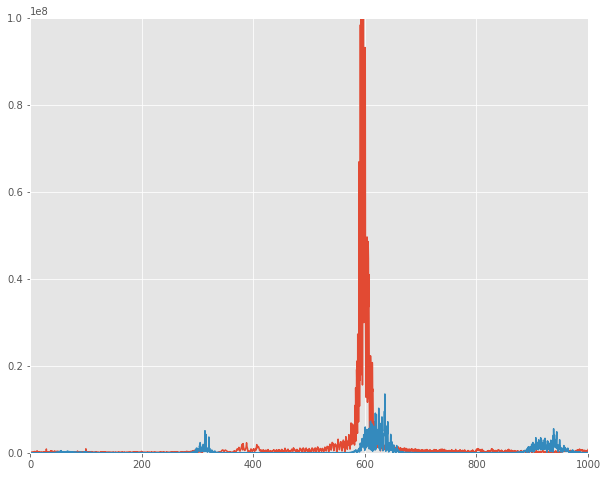

In [32]:
fig = plt.figure(figsize=(10,8))

ax = plt.subplot(111)
ax.plot(JJO.frequencies, JJO.amplitudes)
ax.plot(ARJ.frequencies, ARJ.amplitudes)
ax.set_xlim(0, 1000)
ax.set_ylim(0, 100000000)

plt.show()

The above class will serve as a general starting point for input and processing data, but as I have not fully implemented the class, I will proceed with some stand-alone functions for the rest of the check-in.

In [1]:
import scipy.io.wavfile as wavfile
import scipy
import scipy.fftpack
import numpy as np
from matplotlib import pyplot as plt
from sklearn import metrics

In [174]:
def analyze(file_path, plot = False):
    sample_rate, signal = wavfile.read(file_path)

    tracks = len(signal.shape)
    if tracks == 2:
        signal = signal.sum(axis=1) / 2

    N = signal.shape[0]

    time_total = N / float(sample_rate)

    time_interval = 1.0/sample_rate 

    t = np.arange(0, time_total, time_interval) 
    
    FFT_full = abs(scipy.fft(signal)) #"real"-ize the values
    FFT = FFT_full[range(N//2)] #removes unnecessary values from analysis (symmetry)

    freqs_full = scipy.fftpack.fftfreq(signal.size, t[1]-t[0])
    fft_freqs = np.array(freqs_full)

    freqs = freqs_full[range(N//2)] # one side frequency range
    fft_freqs = np.array(freqs)
    
    if plot == True:
        plt.subplot(211)
        p1 = plt.plot(t, signal, "g") # plotting the signal

        plt.subplot(212)
        p3 = plt.plot(freqs_side, abs(FFT_side), "b") # plotting the positive fft spectrum

        plt.show()
    
    return fft_freqs, np.array(FFT)

In [175]:
handel_freq, handel_amp = analyze("./recordings/handel.wav")
vivaldi_freq, vivaldi_amp = analyze("./recordings/vivaldi.wav")

The two above audio files are real singers singing unaccompanied (both are excerpts from classical pieces that I knew had unaccompanied sections). Length doesn't matter as the FFT transform just needs a sample (although I suspect longer recordings are better, as long as the pitch is held constant).

One of the key things to note here is that I need the singers' recordings to be in .wav format, and also need the notes to be the same pitch. For the two above recordings, the pitches are completely different, so the analysis wont actually work. Nevertheless, I will continue on

### Create a function to identify fundamental note

Although this is labeled data, I still want the environment to have the fundamental frequency to perform the analyses. Finding the fundamental before the harmonics seems reasonable as the fundamental has the highest frequency amplitude, and the identification of harmonics should be identified based on the fundamental.

In [4]:
def fundamental(freq, amp):
    #naive fundamental finder
    loc = amp.argmax()
    fundamental = freq[loc]
    return fundamental

The fundamental could be more accurately found by computing area under the frequency amplitude curve around a midpoint. The largest area under the curve would be the fundamental. This would also allow identification of secondary pitches that have large freq amplitudes.

In [176]:
handel_fund = fundamental(handel_freq, handel_amp)
vivaldi_fund = fundamental(vivaldi_freq, vivaldi_amp)

In [177]:
print(handel_fund, vivaldi_fund)

635.8045212765958 596.9082446808511


In [161]:
def area_fund(freq, amp, tol = 50):
    areas = []
    freqs_loc = []
    i = 0
    while i < len(amp):
        x_range = freq[i:i+tol]
        y_range = amp[i:i+tol]
        area = metrics.auc(x_range, y_range)
        areas.append(area)
        freqs_loc.append(freq[i])
        i += tol 
    areas = np.array(areas)
    fund_loc = areas.argmax()
    fund = freqs_loc[fund_loc]
    return fund

In [162]:
handel_fund_1 = area_fund(handel_freq, handel_amp)
vivaldi_fund_1 = area_fund(vivaldi_freq, vivaldi_amp)

In [164]:
print(handel_fund_1, vivaldi_fund_1)

610.8710106382979 585.9375


## To Do:

1. Calculate the harmonics
2. Create clean superposed sine wave models of singers voices
3. Make figures

    Animate interferences patterns of different singers
    
    Plot harmonic power series plot
    

4. Create a naive algorithm that optimizes vocal placement:

    Given a set of N recordings, pair-wise minimize the weighted sum of the differences of the harmonics of two recordings, return the list of sorted recordings
    

5. Create a better algorithm:

    Given the same set of recordings, pair-wise minimize the weighted sum of a cost function over the harmonics of two recordings, return the list of ordered recordings, also consider voice part/gender.
    
    **COST FUNCTION IDEAS:** The closer the harmonics of the recordings are, the more dissonant it will sound, unless they are within a certain very fine tolerance interval. The naive difference cost function will promote dissonance (ugly beats) over harmony because some singers' harmonics will be minimized, but outside the interval of tolerance. In fact, singers with harmonics very far apart may actually sound "better" than ones with harmonics close together. A cost function that evaluates how close each singer's harmonics are to the **_harmonics of the harmonics_** of the other singer, while also severely penalizing values within the dissonance interval. 
    
    
6. Final visualization ideas:

   Plot of HPS of each singer
   
   Final choir arrangement plot (with intermediate steps: different choir shapes: list, array (nearest neighbour minimisation)
   
   Plot "dissonance" of each singer (the beat frequency metric)
   
   More to come as I see what data I end up generating
   
7. Possible extra tidbits:
    
    Add considerations of spacing between singers and direction (would incorporate phase, so would likely use clean sinusoidal model)
    
   
   
    

WANT TO IMPLEMENT SOMETHING LIKE THIS FOR HPS:

https://gist.github.com/fasiha/957035272009eb1c9eb370936a6af2eb